In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib
from datetime import datetime

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


In [14]:
dataset = pd.read_csv("IMDb_Movies_India.csv", encoding="latin-1")

print("Shape:", dataset.shape)
dataset.head()


Shape: (15509, 10)


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [15]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [16]:
dataset.isnull().sum()


Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [17]:
def safe_extract_year(year_str):
    if pd.isna(year_str):
        return np.nan
    matches = re.findall(r'\b\d{4}\b', str(year_str))
    if matches:
        year = int(matches[-1])
        return year if 1900 <= year <= datetime.now().year else np.nan
    return np.nan


def clean_duration(duration):
    if pd.isna(duration):
        return np.nan
    numbers = re.findall(r'\d+', str(duration))
    return float(numbers[0]) if numbers else np.nan


def clean_votes(votes):
    if pd.isna(votes):
        return np.nan
    return float(str(votes).replace(',', ''))


In [18]:
def clean_votes(votes):
    if pd.isna(votes):
        return np.nan

    votes = str(votes).strip().upper()

    try:
        # Remove currency symbols
        votes = re.sub(r'[^0-9.KM]', '', votes)

        if 'M' in votes:
            return float(votes.replace('M', '')) * 1_000_000
        elif 'K' in votes:
            return float(votes.replace('K', '')) * 1_000
        else:
            return float(votes.replace(',', ''))
    except:
        return np.nan


In [19]:
dataset['Year'] = dataset['Year'].apply(safe_extract_year)
dataset['Duration'] = dataset['Duration'].apply(clean_duration)
dataset['Votes'] = dataset['Votes'].apply(clean_votes)
dataset['Rating'] = pd.to_numeric(dataset['Rating'], errors='coerce')

text_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
dataset[text_cols] = dataset[text_cols].fillna('Unknown')


In [20]:
dataset = dataset.dropna(subset=['Rating'])

for col in ['Duration', 'Year', 'Votes']:
    dataset[col].fillna(dataset[col].median(), inplace=True)

dataset.isnull().sum()


Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [21]:
dataset['Num_Actors'] = dataset[['Actor 1','Actor 2','Actor 3']].apply(
    lambda x: sum(val != 'Unknown' for val in x), axis=1)

dataset['Genre_Count'] = dataset['Genre'].apply(lambda x: len(x.split(',')))
dataset['Movie_Age'] = datetime.now().year - dataset['Year']

dataset['Director_Exp'] = dataset['Director'].map(dataset['Director'].value_counts())

actors = pd.concat([dataset['Actor 1'], dataset['Actor 2'], dataset['Actor 3']])
actor_counts = actors.value_counts()

dataset['Actor1_Pop'] = dataset['Actor 1'].map(actor_counts)
dataset['Actor2_Pop'] = dataset['Actor 2'].map(actor_counts)
dataset['Actor3_Pop'] = dataset['Actor 3'].map(actor_counts)


In [22]:
def cap_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return series.clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

num_cols = dataset.select_dtypes(include=np.number).columns
dataset[num_cols] = dataset[num_cols].apply(cap_outliers_iqr)


ValueError: could not convert string to float: '#Gadhvi (He thought he was Gandhi)'

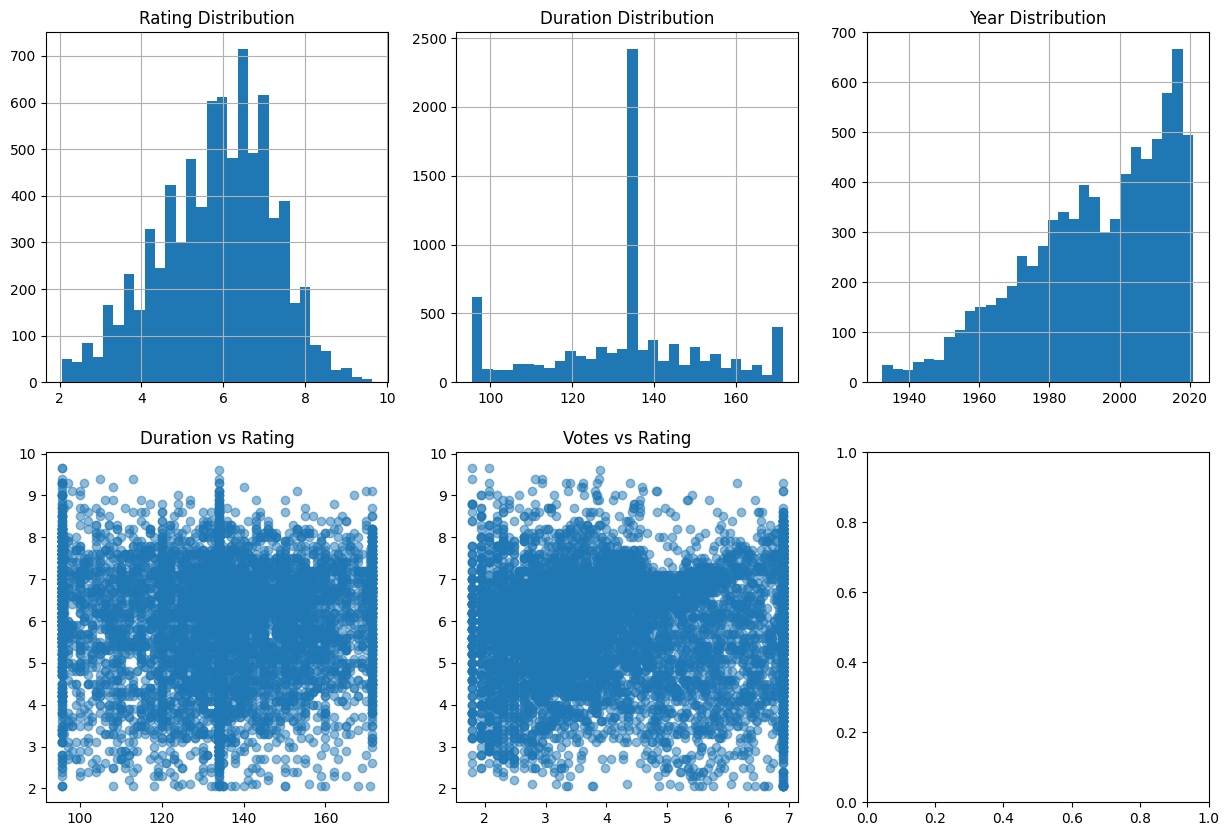

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
dataset['Rating'].hist(bins=30)
plt.title("Rating Distribution")

plt.subplot(2,3,2)
dataset['Duration'].hist(bins=30)
plt.title("Duration Distribution")

plt.subplot(2,3,3)
dataset['Year'].hist(bins=30)
plt.title("Year Distribution")

plt.subplot(2,3,4)
plt.scatter(dataset['Duration'], dataset['Rating'], alpha=0.5)
plt.title("Duration vs Rating")

plt.subplot(2,3,5)
plt.scatter(np.log1p(dataset['Votes']), dataset['Rating'], alpha=0.5)
plt.title("Votes vs Rating")

plt.subplot(2,3,6)
sns.heatmap(dataset.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()


In [ ]:
X = dataset.drop(['Rating', 'Name'], axis=1, errors='ignore')
y = dataset['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=pd.qcut(y, 5, duplicates='drop')
)


In [ ]:
categorical_cols = X_train.select_dtypes(include='object').columns
encoding_maps = {}

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in categorical_cols:
    temp = pd.DataFrame({col: X_train[col], 'rating': y_train})
    mapping = temp.groupby(col)['rating'].mean().to_dict()
    encoding_maps[col] = mapping
    global_mean = y_train.mean()

    X_train_enc[col+'_encoded'] = X_train[col].map(mapping).fillna(global_mean)
    X_test_enc[col+'_encoded'] = X_test[col].map(mapping).fillna(global_mean)

    X_train_enc.drop(col, axis=1, inplace=True)
    X_test_enc.drop(col, axis=1, inplace=True)


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Animation, Family'

In [ ]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_enc = imputer.fit_transform(X_train_enc)
X_test_enc = imputer.transform(X_test_enc)

X_train_enc = scaler.fit_transform(X_train_enc)
X_test_enc = scaler.transform(X_test_enc)


,Model,R2,RMSE,MAE
0,Linear,0.221193,1.211110,0.934167
2,GB,0.213605,1.216996,0.931278
4,SVR,0.171428,1.249205,0.957556
3,XGB,0.161023,1.257024,0.963430
5,MLP,0.143867,1.269812,0.975291
1,RF,0.124968,1.283750,0.982157


In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'SVR': SVR(),
    'Neural Network': MLPRegressor(max_iter=500, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_enc, y_train)
    preds = model.predict(X_test_enc)
    results.append({
        'Model': name,
        'R2': r2_score(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds)
    })

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
results_df


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('Linear', ...), ('GB', ...), ...]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False
,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1


In [ ]:
top_models = results_df.head(3)['Model']

ensemble = VotingRegressor(
    estimators=[(m, models[m]) for m in top_models]
)

ensemble.fit(X_train_enc, y_train)
ensemble_pred = ensemble.predict(X_test_enc)

print("Ensemble R2:", r2_score(y_test, ensemble_pred))


['movie_rating_model.pkl']

In [ ]:
joblib.dump({
    'model': ensemble,
    'scaler': scaler,
    'imputer': imputer,
    'encoding_maps': encoding_maps,
    'global_mean': y_train.mean()
}, "movie_rating_model.pkl")


In [ ]:
def predict_movie_rating(movie_features):
    assets = joblib.load("movie_rating_model.pkl")
    model = assets['model']
    scaler = assets['scaler']
    imputer = assets['imputer']
    encoding_maps = assets['encoding_maps']
    global_mean = assets['global_mean']

    df = pd.DataFrame([movie_features])

    for col, mapping in encoding_maps.items():
        df[col+'_encoded'] = df[col].map(mapping).fillna(global_mean)
        df.drop(col, axis=1, inplace=True)

    df = imputer.transform(df)
    df = scaler.transform(df)

    return round(model.predict(df)[0], 2)


KeyError: 'feature_order'

In [ ]:
example_movie = {
    'Duration': 150,
    'Year': 2019,
    'Votes': 250000,
    'Genre': 'Action, Drama',
    'Director': 'Rajkumar Hirani',
    'Actor 1': 'Aamir Khan',
    'Actor 2': 'Kareena Kapoor',
    'Actor 3': 'Anil Kapoor',
    'Num_Actors': 3,
    'Genre_Count': 2,
    'Movie_Age': 5,
    'Director_Exp': 10,
    'Actor1_Pop': 50,
    'Actor2_Pop': 45,
    'Actor3_Pop': 40
}

predict_movie_rating(example_movie)


NameError: name 'predict_movie_rating' is not defined